In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load

import datetime

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import statistics
from scipy.stats import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time


In [2]:
# Load X and y values
X = load('Obs_NormX.joblib') 
#X

y= load('Obs_y.joblib')
#y

# Hyperparameter tuning

In [3]:
# build a classifier
gbReg = GradientBoostingRegressor(random_state=0)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'n_estimators':[300,500,1000],
              'min_samples_leaf': [5,10,15],
              'max_depth': [2,3,4],
              'learning_rate': [0.1,0.3,0.05,0.01]}

# run grid search
grid_search = GridSearchCV(gbReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 839.55 seconds for 108 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.358 (std: 0.114)
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.353 (std: 0.119)
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.352 (std: 0.113)
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 300}



Accuracy of base Linear Regression model is , 0.757099729229908


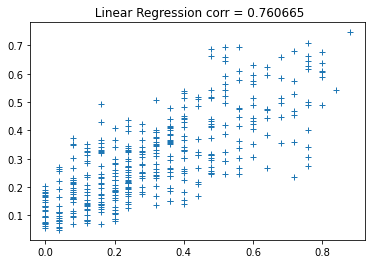

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regLin=GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=5, max_depth= 3,learning_rate=0.01,random_state=0).fit(X_train, y_train)
acc_svr       = round(regLin.score(X_test, y_test) * 100, 2)
print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)
yy_test = regLin.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' Linear Regression corr = %f'%test_corr)
plt.plot(y_test,yy_test,'+')

# test on 2011-2018 Data

In [5]:
# Load X and y values
Xt = load('Obs_NormX_1980-1983_2015-2018.joblib') 
#X

yt= load('Obs_y_1980-1983_2015-2018.joblib')
#y

In [6]:
regLin=GradientBoostingRegressor(n_estimators=500, min_samples_leaf=5, max_depth= 3,learning_rate=0.01,random_state=0).fit(X, y)


Accuracy of base Linear Regression model is , 0.7051241025521677


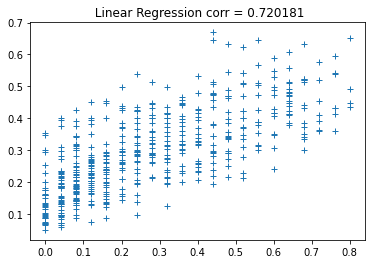

In [7]:
yPred = regLin.predict(Xt)
testcorr = np.corrcoef(yPred,yt)[0,1]
acc_svr       = round(regLin.score(Xt, yt) * 100, 2)
print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)
plt.title(' Linear Regression corr = %f'%testcorr)
plt.plot(yt,yPred,'+')

# Fog Statistics 

In [8]:
y

<xarray.DataArray 'fogdata' (time: 1922)>
array([0.16, 0.28, 0.32, ..., 0.76, 0.72, 0.76])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2014-12-31

In [9]:
dump(y,'TS1dataObs.joblib')

['TS1dataObs.joblib']

In [10]:
yLR=regLin.predict(X)

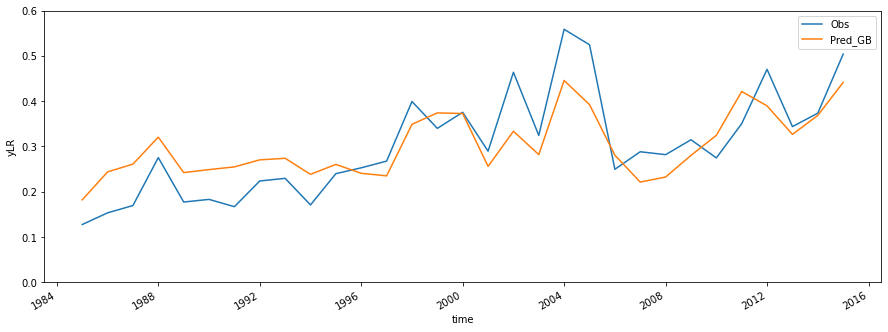

In [11]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataGB.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_GB')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_LinearRegression.jpeg',dpi=300)

In [12]:
ynf=y.where(y==0, drop=True)
ynf

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)

yWd=y.where(y>0.44, drop=True)
yWd

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)

yint1=y.where(y>0,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
yintf

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>0.039,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)

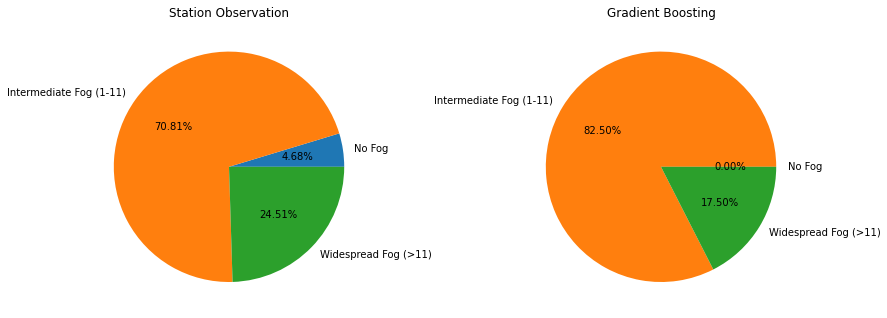

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('Gradient Boosting')
plt.show()

In [14]:
pie1dataGB= [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
dump(pie1dataGB,'pie1dataGB.joblib')

['pie1dataGB.joblib']

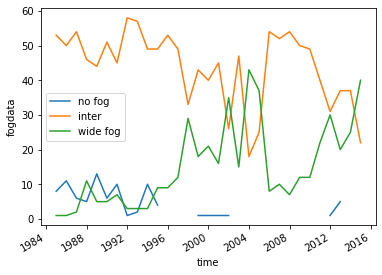

In [15]:
ynf.resample(time='1Y').count().plot(label='no fog')
yintf.resample(time='1Y').count().plot(label='inter')
yWd.resample(time='1Y').count().plot(label='wide fog')
plt.legend()

In [16]:
noFogCounts=np.nan_to_num(ynf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
interFogCounts=yintf.resample(time='1Y').count()
wdFogCounts=yWd.resample(time='1Y').count()


#noFogCountsLR=np.nan_to_num(yLRnf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
noFogCountsLR=0
interFogCountsLR=yLRintf.resample(time='1Y').count()
wdFogCountsLR=np.nan_to_num(yLRWd.yLR.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)

In [17]:
wdFogCountsLR

array([ 2,  3, 13,  4,  6,  7,  1,  1,  2,  5,  8,  4, 17, 26, 21,  9, 18,
        8, 33, 22,  7,  3,  1,  6,  7, 27, 26, 16, 16, 34])

Text(0.5, 1.0, 'Gradient Boosting')

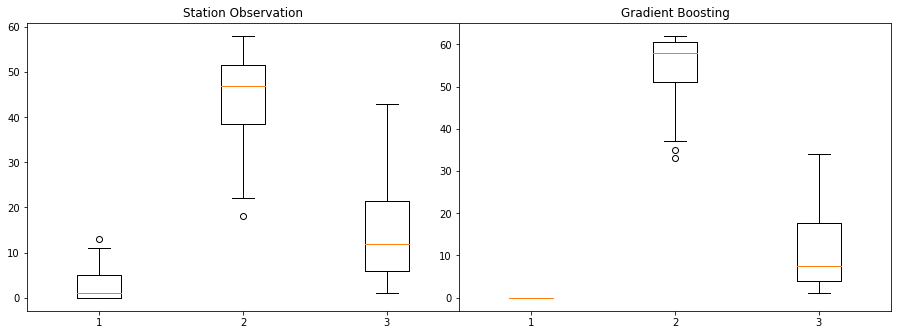

In [18]:
data = [noFogCounts, interFogCounts, wdFogCounts]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot(data)
ax.set_title('Station Observation')

dataLR = [noFogCountsLR, interFogCountsLR.yLR, wdFogCountsLR]
ax1 = fig.add_axes([1,0,1,1])
ax1.boxplot(dataLR)
ax1.set_title('Gradient Boosting')

# Test Data 2011-2018

In [19]:
yLRt=regLin.predict(Xt)

In [20]:
dump(yt,'TS2dataObs.joblib')

['TS2dataObs.joblib']

In [21]:
#dump(yLRt,'TS2dataGB.joblib')

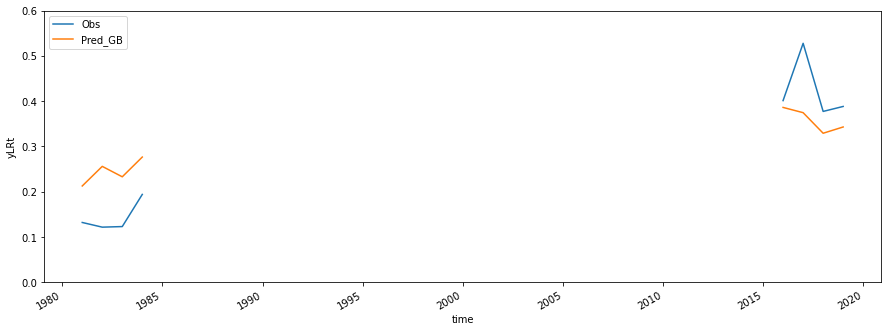

In [22]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt)}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataGB.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_GB')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_GB_2015-2018.jpeg',dpi=300)

In [23]:
ynft=yt.where(yt==0, drop=True)
ynft

yWdt=yt.where(yt>0.44, drop=True)
yWdt

yint1t=yt.where(yt>0,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
yintft

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>0.44,drop=True)
yLRWdt

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>0.039,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
yLRintft

<xarray.Dataset>
Dimensions:  (time: 450)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
Data variables:
    yLRt     (time) float64 0.3024 0.2342 0.4295 0.4476 ... 0.09778 0.2292 0.305

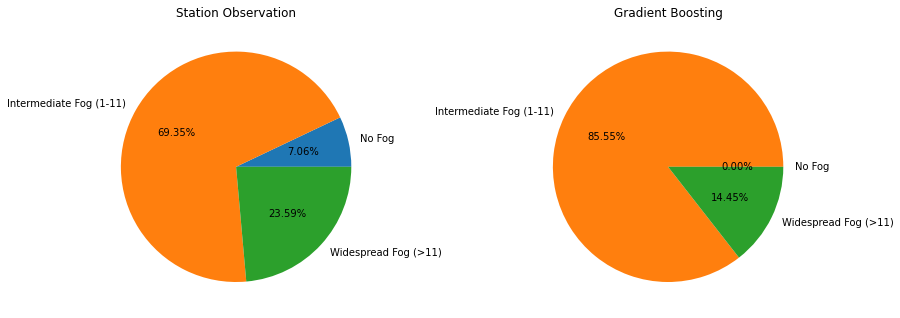

In [24]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('Gradient Boosting')
plt.show()




In [25]:
pie1dataGB= [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
dump(pie1dataGB,'pie2dataGB.joblib')

['pie2dataGB.joblib']